In [1]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data
from dask.distributed import Client
from dask.distributed import as_completed
import openpyxl
import xlsxwriter
import pandas_datareader.data as web
import statsmodels.tsa.stattools as ts
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import pandas_market_calendars as mcal
import os
import sqlite3
import matplotlib.pyplot as plt

In [2]:
end_ = datetime.today()
#start = end - relativedelta(years=2) - relativedelta(days=3)
start_ = end_ - relativedelta(months=64)
start_X2_ = end_ - relativedelta(months=64*2)

nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start_, end_date=end_)

nyse_X2 = mcal.get_calendar('NYSE')
nyse_dates_X2 = nyse.schedule(start_date=start_X2_, end_date=end_)

start = nyse_dates.index[0]
start_X2 = nyse_dates_X2.index[0]

end = nyse_dates.index[-1]
print(start.strftime('%Y-%m-%d'))
print(end.strftime('%Y-%m-%d'))

2017-03-24
2022-07-22


In [3]:
"""
db_filename = '.\\data\\interim\\todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()
"""

"\ndb_filename = '.\\data\\interim\\todo.db'\n\ndb_is_new = not os.path.exists(db_filename)\n\nconn = sqlite3.connect(db_filename)\n\nif db_is_new:\n    print('Need to create schema')\nelse:\n    print('Database exists, assume schema does, too.')\n\nconn.close()\n"

In [4]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','error':'error'}

invert_dict_indexes = {v: k for k, v in dict_indexes.items()}

dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

In [5]:
index_names = ['SP1500', 'SP500', 'SP600', 'SP400']
indexes = ['SPTM','SPY','SLY','MDYG']
sector_names = ['Communication Services ETF', 'Consumer Discretionary ETF', 'Consumer Staples ETF', 'Energy ETF', 'Financials ETF', 'Health Care ETF', 'Industrials ETF', 'Information Technology ETF', 'Materials ETF', 'Real Estate ETF', 'Utilities ETF']
sectors = ['VOX','VCR','VDC','VDE','VFH','VHT','VIS','VGT','VAW','VNQ','VPU']

etf_bonds = ['LQD', 'AGG', 'NEAR', 'IUSB', 'ISTB', 'IMTB', 'ILTB', 'GBF']
etf_muni_bonds = ['MUB', 'SUB', 'MEAR']

etf_treasuries = ['AGZ', 'GOVT', 'BIL', 'SHV', 'SHY', 'IEI', 'IEF', 'TLT']

#M1_MONEY_MULTIPLIER = M1NS/BOGMBASE

FRED_Indicators = [
"ASPUS",\
"AWHAETP",\
"B432RG3A086NBEA",\
"BAA10Y",\
"BACDINA066MNFRBNY",\
"BACTSAMFRBDAL",\
"BAMLC0A0CM",\
"BAMLCC0A1AAATRIV",\
"BAMLCC0A4BBBTRIV",\
"BAMLH0A3HYC",\
"BAMLHYH0A0HYM2TRIV",\
"BOGMBASE",\
"BOGZ1FA105015103Q",\
"BOGZ1FA145050005Q",\
"BOGZ1FA205050005Q",\
"BOGZ1FA315050005Q",\
"BOGZ1FA385050005Q",\
"BOGZ1FL105015105Q",\
"BUSAPPWNSACA",\
"BUSLOANS",\
"CASTHPI",\
"CES0500000003",\
"CES4348400001",\
"CFNAI",\
"CFNAIDIFF",\
"CFSBCACTIVITYMFG",\
"CILACBQ158SBOG",\
"CIVPART",\
"COMREPUSQ159N",\
"CONSUMER",\
"CP",\
"CPALTT01USQ657N",\
"CPIAUCSL",\
"CSCICP03USM665S",\
"CSUSHPINSA",\
"CUSR0000SEHA",\
"CUUR0000SEHA",\
"DALLCIACBEP",\
"DCOILBRENTEU",\
"DCOILWTICO",\
"DEXCHUS",\
"DEXUSUK",\
"DFF",\
"DFII10",\
"DGORDER",\
"DGS1",\
"DGS10",\
"DGS1MO",\
"DGS2",\
"DGS30",\
"DGS3MO",\
"DGS5",\
"DRBLACBS",\
"DRCCLACBS",\
"DRSFRMACBS",\
"DTB3",\
"DTWEXBGS",\
"EMRATIO",\
"ERENTUSQ176N",\
"ETOTALUSQ176N",\
"FEDFUNDS",\
"FGCCSAQ027S",\
"FPCPITOTLZGUSA",\
"GASREGW",\
"GDPC1",\
"GFDEBTN",\
"GFDEGDQ188S",\
"GOLDAMGBD228NLBM",\
"GVZCLS",\
"HDTGPDUSQ163N",\
"HOSMEDUSM052N",\
"IC4WSA",\
"ICSA",\
"IIPUSNETIQ",\
"INDPRO",\
"INTDSRUSM193N",\
"IRLTLT01USM156N",\
"KCFSI",\
"LES1252881600Q",\
"LEU0252918500Q",\
"LFWA64TTUSM647S",\
"LRUN64TTUSQ156S",\
"LXXRCSA",\
"M1",\
"M1V",\
"M1NS",\
"M2V",\
"MABMM301USM189S",\
"MANMM101USA189S",\
"MEFAINUSA672N",\
"MEHOINUSA672N",\
"MEPAINUSA672N",\
"MICH",\
"MOGMBASE",\
"MORTGAGE30US",\
"MPRIME",\
"MSPUS",\
"MZMSL",\
"NEWORDER",\
"NFCI",\
"NROU",\
"NYSTHPI",\
"PAYEMS",\
"PCE",\
"PERMIT",\
"POP",\
"POPTOTUSA647NWDB",\
"PPIACO",\
"PRFI",\
"PSAVERT",\
"Q10096USQ144NNBR",\
"RECPROUSM156N",\
"RSAHORUSQ156S",\
"SPCS20RSA",\
"STLFSI2",\
"T10Y2Y",\
"T10Y3M",\
"T10YIE",\
"T5YIE",\
"T5YIFR",\
"TB3MS",\
"TCU",\
"TDSP",\
"TEDRATE",\
"TOTALSA",\
"TREAST",\
"TTLHH",\
"TWEXB",\
"UMCSENT",\
"U6RATE",\
"UNRATE",\
"USALOLITONOSTSAM",\
"USPHCI",\
"USREC",\
"USROA",\
"USROE",\
"USSLIND",\
"USSTHPI",\
"VIXCLS",\
"VXVCLS",\
"WDFUELLA",\
"WGS3MO",\
"WILLLRGCAPVAL",\
"WILLMICROCAPPR",\
"WPU0911",\
"WPUSI019011",\
"WPU101",\
"WTB3MS"    
]

currencies = ['EURUSD=X','GBPUSD=X','AUDUSD=X','BRLUSD=X','JPY=X']
#doesn't work ,'B0=F'
future_commodities_nSP500 = list(['UUP','^IRX','^GSPC','ES=F','YM=F','NQ=F','RTY=F','ZB=F','ZN=F','ZF=F','ZT=F','GC=F','MGC=F','SI=F','SIL=F','PL=F','HG=F','PA=F','CL=F','HO=F','NG=F','RB=F','BZ=F','ZC=F','ZO=F','KE=F','ZR=F','ZM=F','ZL=F','ZS=F','GF=F','HE=F','LE=F','CC=F','KC=F','CT=F','LBS=F','OJ=F','SB=F'])

etf_bonds = [*etf_bonds,*etf_muni_bonds,*etf_treasuries]

In [6]:
SP500ticker_list = pd.read_html('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
SP600ticker_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[1]
SP400ticker_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[0]


In [7]:
sp500 = SP500ticker_list['Symbol']
sp500 = [w.replace('.', '-') for w in sp500]
sp600 = SP600ticker_list['Ticker symbol']
sp600 = [w.replace('.', '-') for w in sp600]
sp400 = SP400ticker_list['Ticker symbol']
sp400 = [w.replace('.', '-') for w in sp400]


In [8]:
len(sp500)+len(sp600)+len(sp400)

1505

In [9]:
print(len(sp500))
SP1500 = list()
SP1500.extend(sp500)
sp600 = list(set(sp600).difference(SP1500))
print(len(sp600))
SP1500.extend(sp600)
sp400 = list(set(sp400).difference(SP1500))
print(len(sp400))
SP1500.extend(set(sp400).difference(SP1500))

503
601
401


In [10]:
#>.5The time series is mean reverting
#=.5 time series is a Geometric Brownian Motion
#<.5 time series is trending

def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [11]:
sp1500_index_df = pd.DataFrame()

lists = ["sp500","sp600","sp400"]

for l in lists:
    if(l=='sp500'):
        df = pd.DataFrame(sp500,columns=['Symbol'])
        print(len(df))
        #range_ = 
        #print(range_)
        df['Market Index'] = pd.Series(["SP500" for x in range(0,len(df.index),1)])
    elif(l=='sp600'):
        df = pd.DataFrame(np.array(sp600),columns=['Symbol'])        
        print(len(df))        
        df['Market Index'] = pd.Series(["SP600" for x in range(len(df.index))])
        df.index = range(len(sp500),(len(sp500)+len(df.index)),1)        
    else:
        df = pd.DataFrame(np.array(sp400),columns=['Symbol'])
        print(len(df))
        df['Market Index'] = pd.Series(["SP400" for x in range(len(df.index))])
        df.index = range((len(sp500)+len(sp600)),(len(sp500)+len(sp600)+len(df.index)),1)
    sp1500_index_df = pd.concat([sp1500_index_df,df],axis=0)

503
601
401


In [12]:
len(sp1500_index_df)-len(SP1500)

0

In [13]:
def Fred_Data(npa):
    name = npa[0]
    start_ = npa[1]
    end_ = npa[2]
    nyse_dates_ = npa[3]
    
    temp = web.DataReader(str(name), 'fred', start_, end_)
    #temp = web.DataReader(npa[1][0],'fred',start,end)
    temp = temp.asfreq('D').interpolate(method='time',limit_direction='forward',limit_area='inside').reindex(nyse_dates_.index)
    temp.columns = ['Value']
    #temp.index = pd.to_datetime(temp.index)
    
    #temp['Symbol'] = name
    
    #print(temp)
    #temp_new = temp.asfreq('D').interpolate(method='time')    
    temp_dates = pd.date_range(temp.index[0].strftime('%Y-%m-%d'), temp.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_.index[(nyse_dates_.index >= temp_dates[0]) & (nyse_dates_.index <= temp_dates[-1])]
    temp_new = temp.reindex(nyse_inbetween_temp_dates)
    temp_new['Symbol'] = name
    
    #temp = temp.resample(frequency).mean().dropna()
    return(temp_new)
    #return(temp)

In [14]:

def dl(npa):
    name = npa[0]
    start_ = npa[1]
    end_ = npa[2]
    nyse_dates_ = npa[3]
    subset = yf.download(name, start=start_, end=end_, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    
    temp_new = subset.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates_.index)
    temp_dates = pd.date_range(subset.index[0].strftime('%Y-%m-%d'), subset.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_.index[(nyse_dates_.index >= temp_dates[0]) & (nyse_dates_.index <= temp_dates[-1])]
    temp_new = temp_new.reindex(nyse_inbetween_temp_dates)
    subset_ = temp_new
    subset_['Symbol'] = name

    return (subset_)
    
def dl2(assets):

    yahoo_financials = YahooFinancials(assets)

    data = yahoo_financials.get_historical_price_data(start_date=start_date.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d'), time_interval='daily')
    return(data)

In [15]:
def getStock(npa):
    symbol = npa[0]
    start_=npa[1]
    end_=npa[2]
    
    data_ = yf.download(symbol, start=start_,end=end_)
  
    return([symbol,data_])

In [16]:
def getTickerData(npa):
    symbol = npa[0]
    
    stock_data = yf.Ticker(symbol) 
    return([symbol,stock_data])

In [17]:
def getSector(npa):
    #position = npa[0]
    symbol = npa[0]
    #start_=npa[2]
    #end_=npa[3]
    
    tickerdata = yf.Ticker(symbol)
    
    if 'sector' in tickerdata.info:
        sector = tickerdata.info['sector']
    else:
        sector = 'error'

    if 'industry' in tickerdata.info:
        industry = tickerdata.info['industry']
    else:
        industry = 'error'

    return([symbol,sector,industry])

In [18]:
def derive_price_supply_trends(npa_):
    name = npa_[0]
    data = npa_[1]
    nyse_dates_ = npa_[2]
    
    temp_new = data.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates_.index)
    temp_dates = pd.date_range(data.index[0].strftime('%Y-%m-%d'), data.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_.index[(nyse_dates_.index >= temp_dates[0]) & (nyse_dates_.index <= temp_dates[-1])]
    temp_new = temp_new.reindex(nyse_inbetween_temp_dates)
    
    data_ = temp_new
    data_['Symbol'] = name

    """
    if(np.sum(duplicates==names_prices[n])>0):
        #potential duplicate
        if((np.sum((np.unique(prices_df['Symbol']))==n))>0):
            pass
        else:
            prices_df = pd.concat([prices_df,data_],axis=0)            
    else:
    """
    
    data_['buy_volume_pct'] = (data_['Adj Close']-data_['Low'])/(data_['High']-data_['Low'])
    data_['sell_volume_pct'] = (data_['Adj Close']-data_['High'])/(data_['High']-data_['Low'])
    
    data_['daily_buy_vol'] = data_['buy_volume_pct']*data_['Volume']
    
    data_['daily_sell_vol'] = data_['sell_volume_pct']*data_['Volume']
    
    data_['net_daily_vol'] = data_['daily_buy_vol']+data_['daily_sell_vol']
    
    data_['20td_trend_vol'] = data_['net_daily_vol'].rolling(20).sum()
    
    data_['20td_tot_daily_vol'] = data_['Volume'].rolling(20).sum()
    
    data_['20td_trend_vol'] = data_['net_daily_vol'].rolling(20).sum()
    
    data_['20td_trend_vol_factor'] = data_['20td_trend_vol']/data_['20td_tot_daily_vol']
    
    data_['20td_tvf_rng_div_2'] = (data_['20td_trend_vol_factor'].rolling(20).max()-data_['20td_trend_vol_factor'].rolling(20).min())/2
    
    data_['20td_tvf_vel'] = data_['20td_trend_vol_factor']/data_['20td_tvf_rng_div_2']    
    
    data_['trailing_1yr_max'] = (pd.DataFrame(data_)['High']).rolling(252).max()
    data_['MIN_Lookback_One_Year'] = data_['trailing_1yr_max'].rolling(252).min()
    #data_['MIN_Lookback_6_Months'] = data_['trailing_1yr_max'].rolling(126).min()
    data_['MIN_Lookback_2_Months'] = data_['trailing_1yr_max'].rolling(42).min()
    data_['MIN_Lookback_1_Months'] = data_['trailing_1yr_max'].rolling(21).min()

    data_['trailing_1yr_min'] = (pd.DataFrame(data_)['Low']).rolling(252).min()
    
    data_['supply_trend_1yr'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(252).min()
    
    #data_['supply_trend_180d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(126).min()
    
    #data_['supply_trend_90d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(63).min()
    
    data_['supply_trend_60d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(42).min()
    
    data_['supply_trend_30d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(21).min()

    data_['trailing_60d_max'] = (pd.DataFrame(data_)['High']).rolling(42).max()
    data_['trailing_60d_min'] = (pd.DataFrame(data_)['Low']).rolling(42).min()
    
    data_['trailing_30d_max'] = (pd.DataFrame(data_)['High']).rolling(21).max()
    data_['trailing_30d_min'] = (pd.DataFrame(data_)['Low']).rolling(21).min()
    
    data_['90dSMA'] = (pd.DataFrame(data_)['Adj Close']).rolling(63).mean()
    
    data_['90dSDev'] = (pd.DataFrame(data_)['Adj Close']).rolling(63 ).std()
    
    data_['TP'] = (data_['Adj Close'] + data_['Low'] + data_['High'])/3
    data_['21dstdTP'] = data_['TP'].rolling(21).std(ddof=0)
    data_['21dMA-TP'] = data_['TP'].rolling(21).mean()
    data_['21dBOLU'] = data_['21dMA-TP'] + 2*data_['21dstdTP']
    data_['21dBOLD'] = data_['21dMA-TP'] - 2*data_['21dstdTP']    

    data_['trailing_risk_40d_max'] = (pd.DataFrame(data_)['High']).rolling(40).max()
    data_['trailing_risk_40d_min'] = (pd.DataFrame(data_)['Low']).rolling(40).min()
    
    data_['risk_per_share'] = data_['trailing_risk_40d_max']-data_['trailing_risk_40d_min']
    
    data_['30d_vol'] = (pd.DataFrame(data_)['Volume']).rolling(21).sum()
    data_['30d_vol_2yr'] = data_['30d_vol'].rolling(512).mean()
    data_['volume_factor'] = data_['30d_vol']/data_['30d_vol_2yr']
    
    #data_['1YMF'] = (data_['Adj Close']-data_['MIN_Lookback_One_Year']) + (data_['Adj Close']-data_['MIN_Lookback_6_Months']) + (data_['Adj Close']-data_['MIN_Lookback_2_Months']) + (data_['Adj Close']-data_['MIN_Lookback_1_Months'])
    data_['1YMF'] = (data_['Adj Close']-data_['MIN_Lookback_One_Year']) + (data_['Adj Close']-data_['MIN_Lookback_2_Months']) + (data_['Adj Close']-data_['MIN_Lookback_1_Months'])
    
    data_['risk_trend_factor'] = data_['1YMF']/data_['risk_per_share']
    
    return(data_)

In [19]:
def calculateMetrics(data_):
    
    df_line = data_[['Symbol','buy_volume_pct','sell_volume_pct','daily_buy_vol','daily_sell_vol','net_daily_vol','20td_trend_vol','20td_tot_daily_vol','20td_trend_vol','20td_trend_vol_factor','20td_tvf_rng_div_2','20td_tvf_vel','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','risk_per_share','volume_factor','Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']].iloc[[-1]].reset_index().set_index('Symbol')
    name = df_line.index[0]
    adf = ts.adfuller(data_['Adj Close'].values)[1]
    
    hurst_ = hurst(data_['Adj Close'].values)
    
    #temp_ = prices_df[prices_df['Symbol']=='GO']
    #temp__ = temp_[['Symbol','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','risk_per_share','volume_factor','Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']].iloc[[-1]].reset_index().set_index('Symbol')

    try:
        adf = ts.adfuller(data_['Adj Close'].values)[1]
    except:
        adf = 'error'

    try:
        hurst_ = hurst(data_['Adj Close'].values)
    except:
        hurst_ = 'error'

    temp = pd.concat([df_line,pd.DataFrame([adf],index=[name],columns=['adf']),pd.DataFrame([hurst_],index=[name],columns=['hurst'])],axis=1)
    temp.columns = ['Date',*temp.columns[1:]]
    return(temp)
    
    """
    n_ = data_df['Symbol'].values[-1]
    
    latest_p = pd.DataFrame(data_df)['Adj Close'][-1]
    oneYearDate = pd.DataFrame(data_df)['Adj Close'][[-1]].index[0] - relativedelta(years=1)
    
    #separate subset for past year.
    past_year = data_df[data_df.index>=oneYearDate.strftime('%Y-%m-%d')]
    
    #np.max(npa[np.where(np.array(names_prices)=='GBX')[0][0]]['High'])
    #max_2y = pd.DataFrame(data_df)['High'].rolling(504).max()[-1]
    #min_2y = pd.DataFrame(data_df)['Low'].rolling(504).min()[-1]
    
    #quantiles_close_2y = data_df['Adj Close'].rolling(504).quantile(q=[0, .02, .09, .25, .5, .75, .91, .98, 1])[-1]
    #quantiles_close_2y = data_df['Adj Close'].quantile(q=[0, .02, .09, .25, .5, .75, .91, .98, 1])
    
    std_2y = pd.DataFrame(data_df)['Adj Close'].rolling(504).std()[-1]
    mean_2y = pd.DataFrame(data_df)['Adj Close'].rolling(504).mean()[-1]
    
    #max_1y = past_year['High'].rolling(252).max()[-1]
    #min_1y = past_year['Low'].rolling(252).min()[-1]
    
    #quantiles_close_1y = data_df['Adj Close'].rolling(252).quantile(q=[0, .02, .09, .25, .5, .75, .91, .98, 1])[-1]
    #quantiles_close_1y = past_year['Adj Close'].quantile(q=[0, .02, .09, .25, .5, .75, .91, .98, 1])
    
    std_1y = past_year['Adj Close'].rolling(252).std()[-1]
    mean_1y = past_year['Adj Close'].rolling(252).mean()[-1]
    
    risk_trend_factor = data_df['risk_trend_factor'][-1]
    
    supply_trend_1yr = data_df['supply_trend_1yr'][-1]
    #supply_trend_180d = data_df['supply_trend_180d'][-1]
    #supply_trend_90d = data_df['supply_trend_90d'][-1]
    supply_trend_60d = data_df['supply_trend_60d'][-1]
    supply_trend_30d = data_df['supply_trend_30d'][-1]
    
    MIN_Lookback_One_Year = data_df['MIN_Lookback_One_Year'][-1]
    #MIN_Lookback_6_Months = data_df['MIN_Lookback_6_Months'][-1]
    MIN_Lookback_2_Months = data_df['MIN_Lookback_2_Months'][-1]
    MIN_Lookback_1_Months = data_df['MIN_Lookback_1_Months'][-1]
    
    adf = ts.adfuller(data_df['Adj Close'].values)[1]
    
    hurst_ = hurst(data_df['Adj Close'].values)

    volume_factor = data_df['volume_factor'][-1]
    vol_30d = data_df['30d_vol'][-1]
    vol_30d_2yr = data_df['30d_vol_2yr'][-1]
    
    pct_2yr = (latest_p - min_2y)/(max_2y-min_2y)
    pct_1yr = (latest_p - min_1y)/(max_1y-min_1y)
    
    ymf = data_df['1YMF'][-1]
    
    return([n_,max_2y,min_2y,std_2y,mean_2y,max_1y,min_1y,std_1y,mean_1y,latest_p,*quantiles_close_2y,*quantiles_close_1y,risk_trend_factor,supply_trend_1yr,supply_trend_60d,supply_trend_30d,vol_30d_2yr,pct_1yr,pct_2yr,MIN_Lookback_One_Year, MIN_Lookback_2_Months, MIN_Lookback_1_Months,vol_30d,volume_factor,adf,hurst_,ymf])
    """

In [20]:
def extractTickerValues(npa):
    
    n_ = npa[0]
    r_ = npa[1]
    #print(r_)
    print(n_)

    subset = pd.DataFrame([r_.info])

    others = ['quarterly_balance_sheet','quarterly_cashflow','quarterly_dividends','quarterly_earnings','quarterly_financials','mutualfund_holders','options','sustainability']

    o_items = []

    #print(r_)
    for o in others:
        if(np.sum(np.array(dir(r_))==[o])>0):
            o_item = getattr(r_, o)
            o_items.append([o,o_item])            

    
    values = pd.DataFrame()

    trackers = ['beta','currentRatio','debtToEquity','dividendRate','dividendYield','earningsGrowth','earningsQuarterlyGrowth','ebitda','ebitdaMargins','exDividendDate','forwardEPS','forwardPE','freeCashflow','grossMargins','grossProfits','heldPercentInstitutions','industry','lastDividendDate','lastDividendValue','lastSplitDate','lastSplitFactor','marketCap','operatingCashflow','operatingMargins','payoutRatio','pegRatio','priceToBook','priceToSalesTrailing12Months','profitMargins','quickRatio','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','sector','sharesOutstanding','shortRatio','totalAssets','totalCash','totalCashPerShare','totalDebt','totalRevenue','trailingEPS','trailingAnnualDividendRate','trailingAnnualDividendYield','trailingPE']

    for t in trackers:
        if(np.sum(np.where(subset.columns==t))==0):
            values = pd.concat([values,pd.DataFrame('error',index=[n_],columns=[t])],axis=1)
        else:
            values = pd.concat([values,pd.DataFrame(subset[t].values[0],index=[n_],columns=[t])],axis=1)

    return([n_,values,o_items])

In [21]:

npa = []
for f in [*future_commodities_nSP500,*currencies]:
    npa.append([f,start_X2,end])
    

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()
future = client.map(getStock, npa)
results_commodities_futures = []
#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_commodities_futures.append("error")
    else:
        results_commodities_futures.append(f.result()) 
client.close()

"""
data_['trailing_risk_40d_max'] = (pd.DataFrame(data_)['High']).rolling(40).max()
data_['trailing_risk_40d_min'] = (pd.DataFrame(data_)['Low']).rolling(40).min()
"""

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


"\ndata_['trailing_risk_40d_max'] = (pd.DataFrame(data_)['High']).rolling(40).max()\ndata_['trailing_risk_40d_min'] = (pd.DataFrame(data_)['Low']).rolling(40).min()\n"

In [22]:
future_commodities_nSP500_df = pd.DataFrame()

for r_df in results_commodities_futures:

        temp_df = r_df[1].asfreq('D').interpolate(method='time',limit_direction='forward',limit_area='inside').reindex(nyse_dates_X2.index)
        temp_dates = pd.date_range(temp_df.index[0].strftime('%Y-%m-%d'), temp_df.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
        nyse_inbetween_temp_dates = nyse_dates_X2.index[(nyse_dates_X2.index >= temp_dates[0]) & (nyse_dates_X2.index <= temp_dates[-1])]
        temp_new = temp_df.reindex(nyse_inbetween_temp_dates)
        temp_new['Symbol'] = r_df[0]

        future_commodities_nSP500_df = pd.concat([future_commodities_nSP500_df,temp_new],axis=0)

In [23]:
future_commodities_nSP500_pvt = pd.pivot_table(future_commodities_nSP500_df, values=['Adj Close'], index=future_commodities_nSP500_df.index,columns=['Symbol'])

In [24]:
future_commodities_nSP500_pvt.columns = future_commodities_nSP500_pvt.columns.droplevel(0)

In [25]:
tbill_df = Fred_Data(['DTB3',start_X2,end,nyse_dates])[['Value']]
tbill_df.columns = ['DTB3']


In [26]:
future_commodities_nSP500_pvt_w_Fred = pd.concat([tbill_df,future_commodities_nSP500_pvt],axis=1)
future_commodities_nSP500_pvt_w_Fred.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_future_commodities_nSP500_pvt_w_Fred.csv')

trending = pd.DataFrame((future_commodities_nSP500_pvt_w_Fred['^GSPC']-future_commodities_nSP500_pvt_w_Fred['^GSPC'].shift(40))>0)
trending.columns = ['trending']
trending_df = pd.concat([future_commodities_nSP500_pvt_w_Fred,trending],axis=1)
future_commodities_trending = trending_df[trending_df['trending']==True]
future_commodities_not_trending = trending_df[trending_df['trending']!=True]
future_commodities_nSP500_pvt_w_Fred.dropna(axis=1, thresh = int(.95*future_commodities_nSP500_pvt_w_Fred.shape[0]), inplace=True)

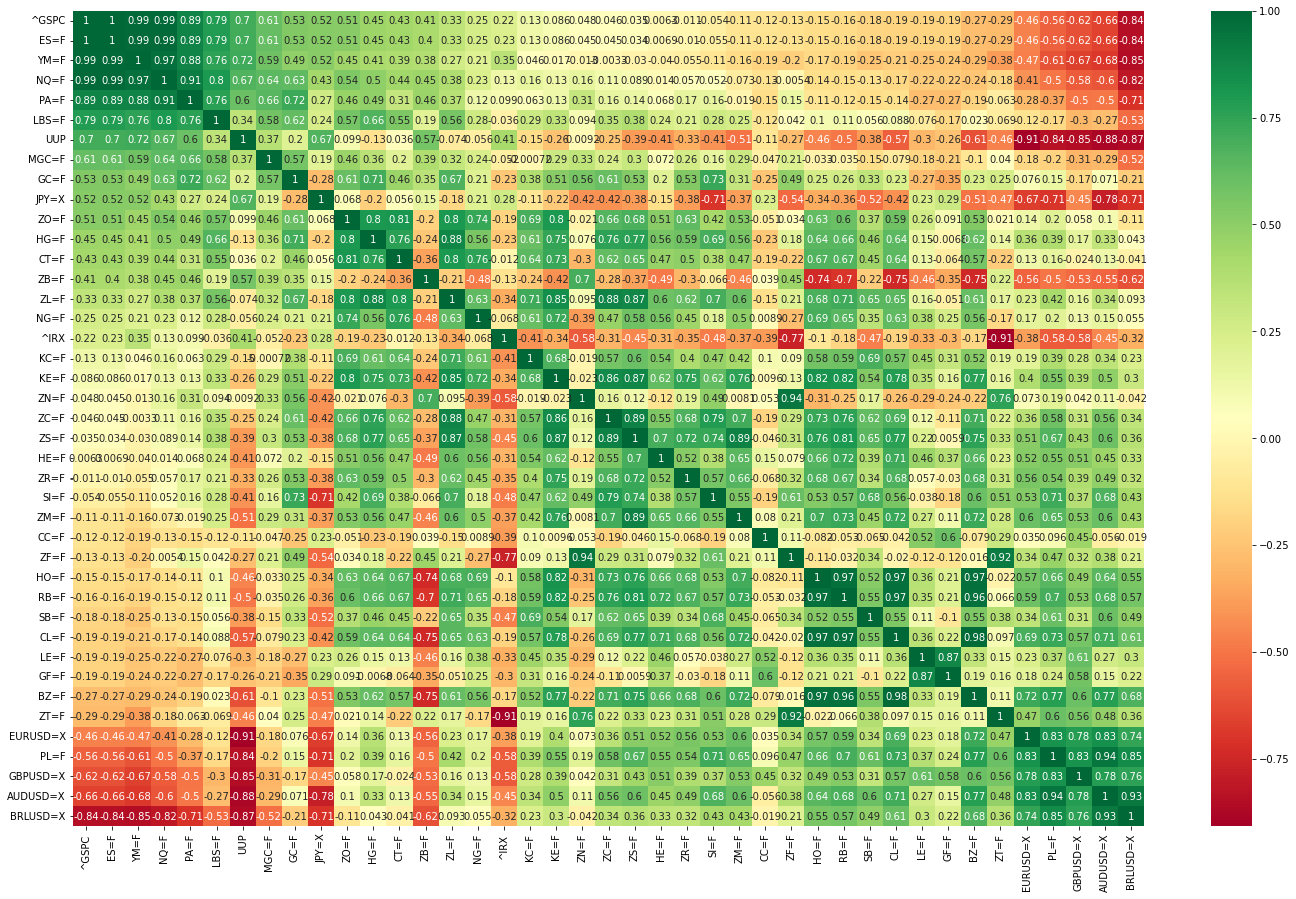

In [27]:
sorted_by_GSPC_future_commodities_corr = future_commodities_nSP500_pvt_w_Fred.corr().sort_values(by='^GSPC',ascending=False,axis=0).sort_values(by='^GSPC',ascending=False,axis=1)
sorted_by_GSPC_future_commodities_corr.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_sorted_by_GSPC_future_commodities_corr.csv')

future_commodities_trending_corr = future_commodities_trending.corr().sort_values(by='^GSPC',ascending=False,axis=0).sort_values(by='^GSPC',ascending=False,axis=1)
sorted_by_GSPC_future_commodities_corr.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_future_commodities_trending_corr.csv')

future_commodities_not_trending_corr = future_commodities_not_trending.corr().sort_values(by='^GSPC',ascending=False,axis=0).sort_values(by='^GSPC',ascending=False,axis=1)
future_commodities_not_trending_corr.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_future_commodities_not_trending_corr.csv')

import seaborn as sns

plt.figure(figsize=(24,15))
sns.heatmap(future_commodities_nSP500_pvt_w_Fred[sorted_by_GSPC_future_commodities_corr.index].corr(),cmap="RdYlGn",annot=True)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_sorted_by_GSPC_future_commodities_corr.png', dpi=300, format='png', bbox_inches='tight')
plt.show()


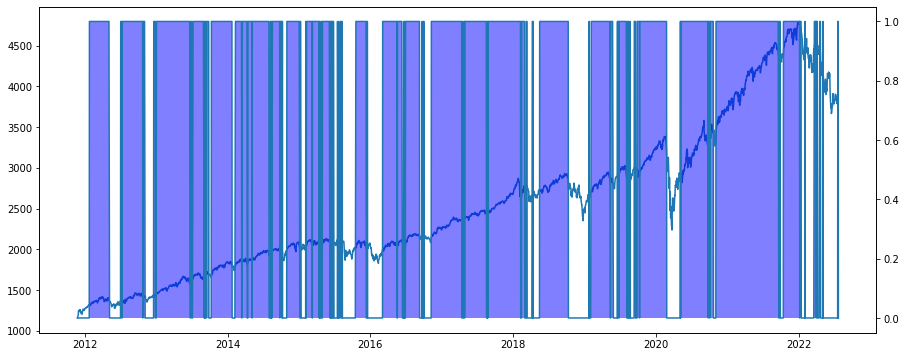

In [28]:
fig, ax1 = plt.subplots( figsize=(15,6) )

ax2 = ax1.twinx()

ax1.plot(trending_df[['^GSPC']])
ax2.plot(trending_df[['trending']])
ax2.fill_between(trending_df.index, 0, 1, where=trending_df['trending'] == True,facecolor='blue', alpha=0.5)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_SP500_trending.png', dpi=300, format='png', bbox_inches='tight')


correlations when trending
1918


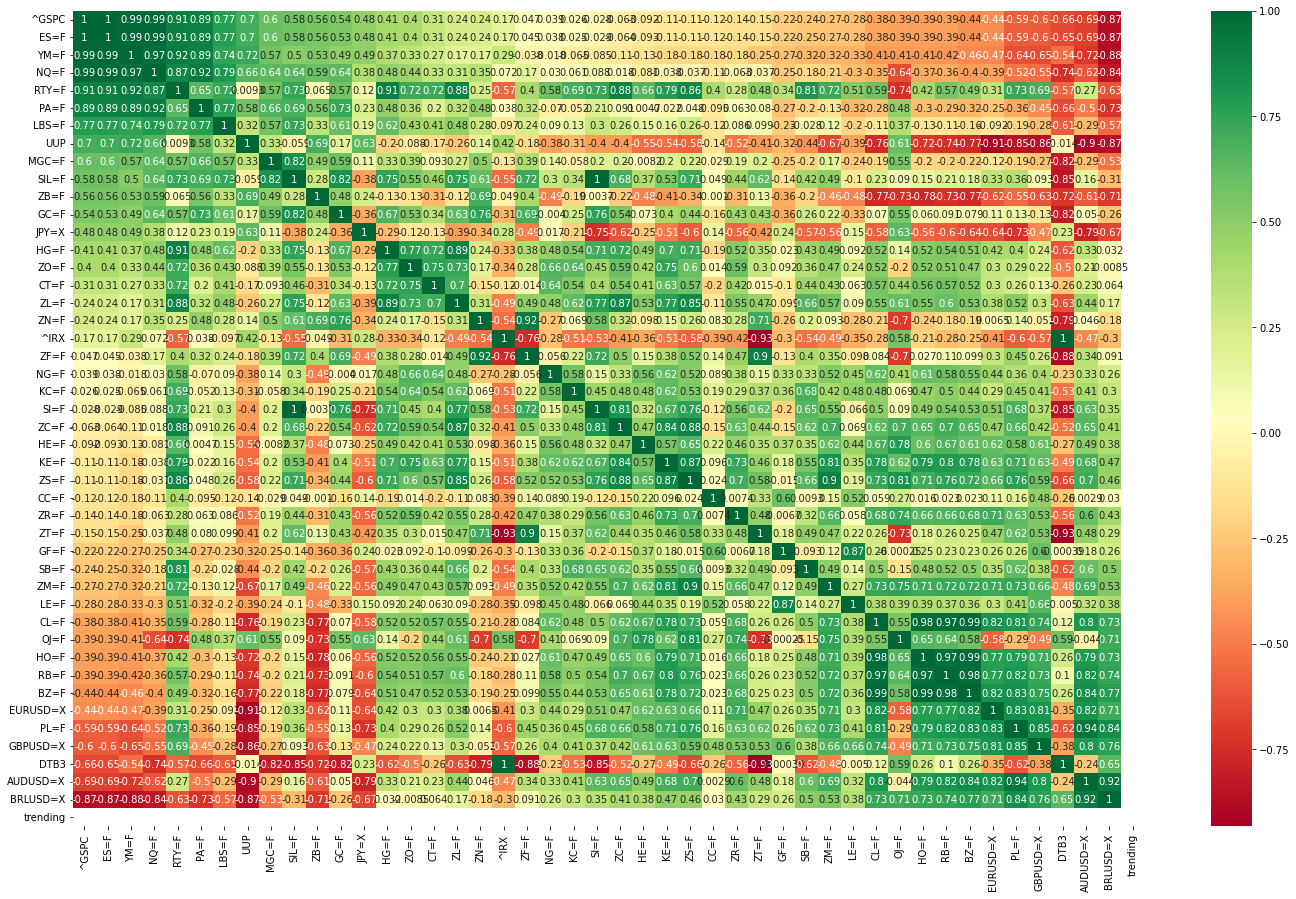

In [29]:
print("correlations when trending")
print(len(future_commodities_trending))

sorted_future_commodities_trending = future_commodities_trending.corr()[['^GSPC']].sort_values(by='^GSPC',ascending=False)

import seaborn as sns

plt.figure(figsize=(24,15))
sns.heatmap(future_commodities_trending[sorted_future_commodities_trending.index].corr(),cmap="RdYlGn",annot=True)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_sorted_by_GSPC_future_commodities_trending_corr.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

correlations when not trending
764


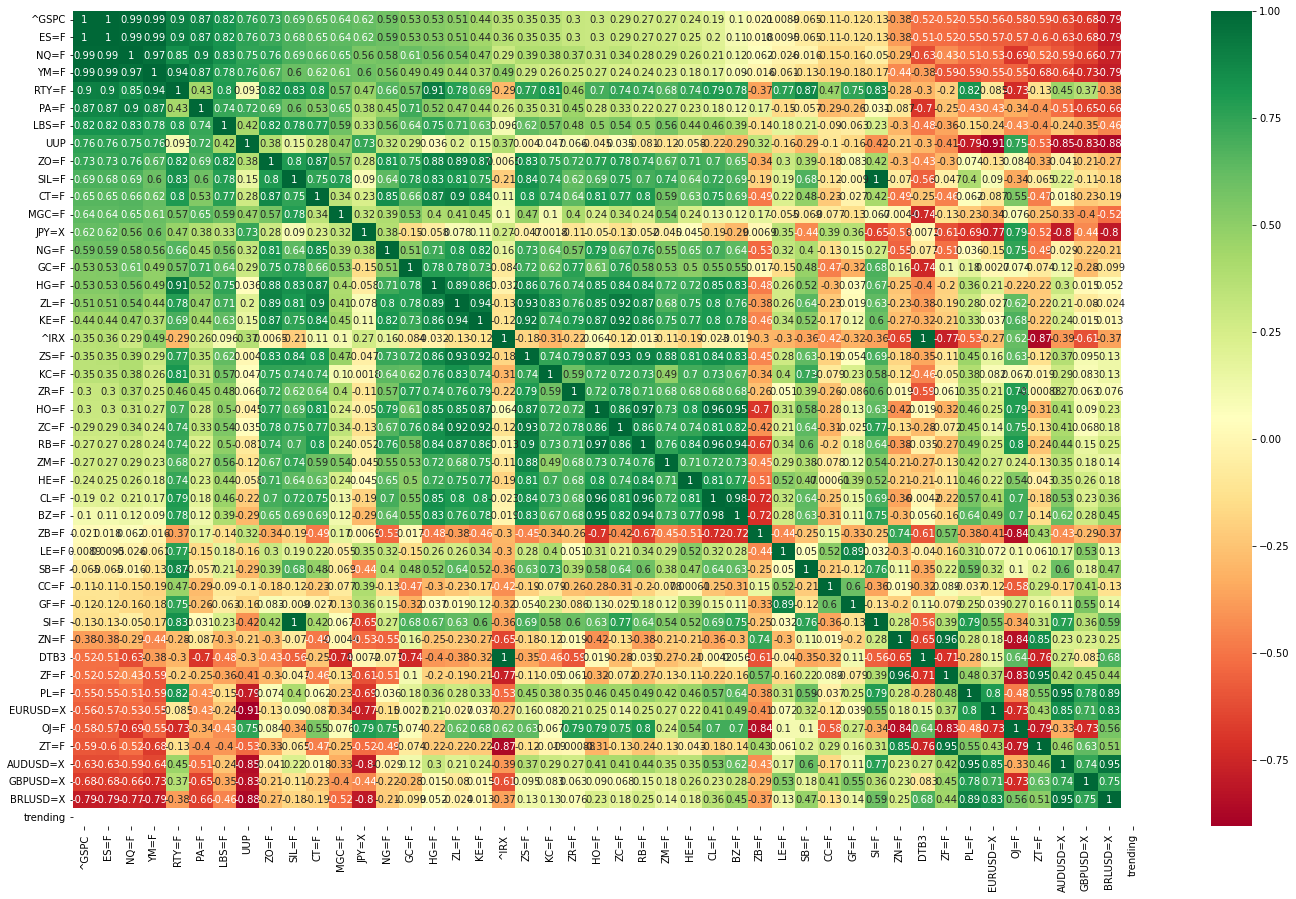

In [30]:
print("correlations when not trending")
print(len(future_commodities_not_trending))

sorted_future_commodities_not_trending = future_commodities_not_trending.corr()[['^GSPC']].sort_values(by='^GSPC',ascending=False)

import seaborn as sns

plt.figure(figsize=(24,15))
sns.heatmap(future_commodities_not_trending[sorted_future_commodities_not_trending.index].corr(),cmap="RdYlGn",annot=True)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_sorted_by_GSPC_future_commodities_not_trending_corr.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

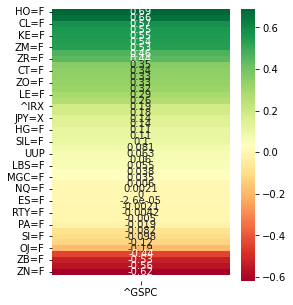

In [31]:
plt.figure(figsize=(4,5))
sns.heatmap((sorted_future_commodities_not_trending-sorted_future_commodities_trending).sort_values(by=['^GSPC'],ascending=False),cmap="RdYlGn",annot=True)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_sorted_by_GSPC_future_commodities_trending-not_trending_corr.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

In [32]:
import scipy

n = len(future_commodities_not_trending)

dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
p_not_trending = pd.DataFrame(2*dist.cdf(-abs(future_commodities_not_trending[sorted_future_commodities_not_trending.index].corr())),columns=future_commodities_not_trending.columns,index=sorted_future_commodities_not_trending.index)

n = len(future_commodities_trending)

dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
p_trending = pd.DataFrame(2*dist.cdf(-abs(future_commodities_trending[sorted_future_commodities_trending.index].corr())),columns=future_commodities_trending.columns,index=sorted_future_commodities_trending.index)
#p_trending = pd.DataFrame([2*dist.cdf(-abs(future_commodities_trending[sorted_future_commodities_trending.index].corr()))],columns=sorted_future_commodities_trending.columns,index=sorted_future_commodities_trending.index)


In [33]:
def highlight_cells(cell):
    #def inner(cell):
    color = 'green' if cell == True else ''
    return 'background-color: {}'.format(color)
    #return inner

In [34]:

temp_all_significant = pd.DataFrame((pd.DataFrame(p_not_trending)<.05)*(pd.DataFrame(p_trending)<.05)*(future_commodities_not_trending[sorted_future_commodities_not_trending.index].corr()*future_commodities_trending[sorted_future_commodities_trending.index].corr())>0)
temp_all_significant_inverted = pd.DataFrame((pd.DataFrame(p_not_trending)<.05)*(pd.DataFrame(p_trending)<.05)*(future_commodities_not_trending[sorted_future_commodities_not_trending.index].corr()*future_commodities_trending[sorted_future_commodities_trending.index].corr())<0)
temp_trend_significant = pd.DataFrame(pd.DataFrame(p_trending)<.05)
temp_not_trend_significant = pd.DataFrame(pd.DataFrame(p_not_trending)<.05)

combined = pd.concat([temp_trend_significant.loc[['^GSPC']].T,temp_not_trend_significant.loc[['^GSPC']].T,temp_all_significant.loc[['^GSPC']].T,temp_all_significant_inverted.loc[['^GSPC']].T],axis=1)
combined.columns = ['trend','not_trend','both','inverted']
display(combined.style.applymap(highlight_cells))



C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


,trend,not_trend,both,inverted
DTB3,True,True,True,False
AUDUSD=X,True,True,True,False
BRLUSD=X,True,True,True,False
BZ=F,True,True,False,True
CC=F,True,True,True,False
CL=F,True,True,False,True
CT=F,True,True,True,False
ES=F,True,True,True,False
EURUSD=X,True,True,True,False
GBPUSD=X,True,True,True,False


In [35]:
#test

import pandas as pd
import datetime as dt
dates = []
for d in pd.read_csv('..\\data\\raw\\sample.csv')['Date']:
    dates.append(dt.datetime.strptime(d, '%d-%b-%y'))

temp = pd.read_csv('..\\data\\raw\\sample.csv',thousands=",")
temp.index = dates
temp = temp.iloc[:,1:]
temp.columns = ['Open','High','Low','Adj Close','Volume']
#temp['Close'] = temp['Close'].astype(float)
temp.sort_index(inplace=True)
temp['Symbol'] = 'Test'

temp_new = derive_price_supply_trends(['temp',temp,nyse_dates]).sort_index(ascending=False)
temp_new.sort_index(inplace=True)
display(temp_new)
display(temp_new[['buy_volume_pct', 'sell_volume_pct', 'daily_buy_vol', 'daily_sell_vol', 'net_daily_vol', '20td_trend_vol', '20td_tot_daily_vol','20td_trend_vol_factor', '20td_tvf_rng_div_2', '20td_tvf_vel']])
display(calculateMetrics(temp_new))
#


,Open,High,Low,Adj Close,Volume,Symbol,buy_volume_pct,sell_volume_pct,daily_buy_vol,daily_sell_vol,...,21dBOLU,21dBOLD,trailing_risk_40d_max,trailing_risk_40d_min,risk_per_share,30d_vol,30d_vol_2yr,volume_factor,1YMF,risk_trend_factor
2017-10-03,2530.34,2535.13,2528.85,2534.58,1900000.0,temp,0.912420,-0.087580,1.733599e+06,-1.664013e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-04,2533.48,2540.53,2531.80,2537.74,1800000.0,temp,0.680412,-0.319588,1.224742e+06,-5.752577e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-05,2540.86,2552.51,2540.02,2552.07,1700000.0,temp,0.964772,-0.035228,1.640112e+06,-5.988791e+04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-06,2547.44,2549.41,2543.79,2549.33,1600000.0,temp,0.985765,-0.014235,1.577224e+06,-2.277580e+04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-09,2551.39,2551.82,2541.60,2544.73,1500000.0,temp,0.306262,-0.693738,4.593933e+05,-1.040607e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,3899.00,3945.96,3876.58,3900.79,500000.0,temp,0.348948,-0.651052,1.744739e+05,-3.255261e+05,...,4396.787452,3847.988104,4637.30,3858.87,778.43,14100000.0,1.752246e+07,0.804681,-2172.91,-2.791401
2022-05-20,3927.76,3943.42,3810.32,3901.36,400000.0,temp,0.683997,-0.316003,2.735988e+05,-1.264012e+05,...,4351.886394,3840.953606,4637.30,3810.32,826.98,14000000.0,1.752109e+07,0.799037,-2171.20,-2.625456
2022-05-23,3919.42,3981.88,3909.04,3973.75,300000.0,temp,0.888386,-0.111614,2.665157e+05,-3.348435e+04,...,4323.275949,3835.895479,4637.30,3810.32,826.98,13700000.0,1.751973e+07,0.781976,-1954.03,-2.362850
2022-05-24,3942.94,3955.68,3875.13,3941.48,200000.0,temp,0.823712,-0.176288,1.647424e+05,-3.525760e+04,...,4300.746038,3825.927930,4637.30,3810.32,826.98,13200000.0,1.751758e+07,0.753529,-2050.84,-2.479915


,buy_volume_pct,sell_volume_pct,daily_buy_vol,daily_sell_vol,net_daily_vol,20td_trend_vol,20td_tot_daily_vol,20td_trend_vol_factor,20td_tvf_rng_div_2,20td_tvf_vel
2017-10-03,0.912420,-0.087580,1.733599e+06,-1.664013e+05,1.567197e+06,NaN,NaN,NaN,NaN,NaN
2017-10-04,0.680412,-0.319588,1.224742e+06,-5.752577e+05,6.494845e+05,NaN,NaN,NaN,NaN,NaN
2017-10-05,0.964772,-0.035228,1.640112e+06,-5.988791e+04,1.580224e+06,NaN,NaN,NaN,NaN,NaN
2017-10-06,0.985765,-0.014235,1.577224e+06,-2.277580e+04,1.554448e+06,NaN,NaN,NaN,NaN,NaN
2017-10-09,0.306262,-0.693738,4.593933e+05,-1.040607e+06,-5.812133e+05,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-05-19,0.348948,-0.651052,1.744739e+05,-3.255261e+05,-1.510522e+05,-5.412016e+05,13600000.0,-0.039794,0.069523,-0.572389
2022-05-20,0.683997,-0.316003,2.735988e+05,-1.264012e+05,1.471976e+05,1.637660e+05,13400000.0,0.012221,0.094055,0.129938
2022-05-23,0.888386,-0.111614,2.665157e+05,-3.348435e+04,2.330313e+05,-2.618585e+05,13000000.0,-0.020143,0.094055,-0.214161
2022-05-24,0.823712,-0.176288,1.647424e+05,-3.525760e+04,1.294848e+05,6.651433e+05,12400000.0,0.053641,0.114765,0.467395


,Date,buy_volume_pct,sell_volume_pct,daily_buy_vol,daily_sell_vol,net_daily_vol,20td_trend_vol,20td_tot_daily_vol,20td_trend_vol,20td_trend_vol_factor,...,risk_per_share,volume_factor,Adj Close,21dBOLD,21dMA-TP,21dBOLU,90dSMA,90dSDev,adf,hurst
temp,2022-05-25,0.722746,-0.277254,72274.562584,-27725.437416,44549.125168,1.122506e+06,11600000.0,1.122506e+06,0.096768,...,817.45,0.713704,3978.73,3820.506118,4051.824444,4283.142771,4287.030794,207.673021,0.711021,0.419604


In [36]:
npa = []
for i in range(0,len([*SP1500,*indexes,*sectors])):
    npa.append([[*SP1500,*indexes,*sectors][i],start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d')])
    
# = getStock(npa[0])
    
client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()
future = client.map(getStock, npa)
results_prices = []
#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_prices.append("error")
    else:
        results_prices.append(f.result()) 
client.close()


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [37]:
npa = []
for i in range(0,len([*SP1500,*indexes,*sectors])):
    npa.append([[*SP1500,*indexes,*sectors][i]])

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(getTickerData, npa)

results_ticker_data = []

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_ticker_data.append("error")
    else:
        results_ticker_data.append(f.result()) 
#client.restart()
client.close()


In [38]:
print(results_ticker_data[0][1].info)
print(results_ticker_data[0][1].quarterly_balance_sheet)
print(results_ticker_data[0][1].quarterly_cashflow)
#print(results_ticker_data[0][1].quarterly_dividends)
print(results_ticker_data[0][1].quarterly_earnings)
print(results_ticker_data[0][1].quarterly_financials)


{'zip': '94128-8999', 'sector': 'Financial Services', 'fullTimeEmployees': 21500, 'longBusinessSummary': 'Visa Inc. operates as a payments technology company worldwide. The company facilitates digital payments among consumers, merchants, financial institutions, businesses, strategic partners, and government entities. It operates VisaNet, a transaction processing network that enables authorization, clearing, and settlement of payment transactions. In addition, the company offers card products, platforms, and value-added services. It provides its services under the Visa, Visa Electron, Interlink, VPAY, and PLUS brands. Visa Inc. was founded in 1958 and is headquartered in San Francisco, California.', 'city': 'San Francisco', 'phone': '650 432 3200', 'state': 'CA', 'country': 'United States', 'companyOfficers': [], 'website': 'https://usa.visa.com', 'maxAge': 1, 'address1': 'PO Box 8999', 'industry': 'Credit Services', 'ebitdaMargins': 0.70605004, 'profitMargins': 0.51101, 'grossMargins':

In [39]:
results_ticker_data[0][1].info

{'zip': '94128-8999',
 'sector': 'Financial Services',
 'fullTimeEmployees': 21500,
 'longBusinessSummary': 'Visa Inc. operates as a payments technology company worldwide. The company facilitates digital payments among consumers, merchants, financial institutions, businesses, strategic partners, and government entities. It operates VisaNet, a transaction processing network that enables authorization, clearing, and settlement of payment transactions. In addition, the company offers card products, platforms, and value-added services. It provides its services under the Visa, Visa Electron, Interlink, VPAY, and PLUS brands. Visa Inc. was founded in 1958 and is headquartered in San Francisco, California.',
 'city': 'San Francisco',
 'phone': '650 432 3200',
 'state': 'CA',
 'country': 'United States',
 'companyOfficers': [],
 'website': 'https://usa.visa.com',
 'maxAge': 1,
 'address1': 'PO Box 8999',
 'industry': 'Credit Services',
 'ebitdaMargins': 0.70605004,
 'profitMargins': 0.51101,
 

In [40]:
npa = []
results_ticker_names = [r[0] for r in results_ticker_data]
for n in range(0,len(results_ticker_names),1):
    npa.append([results_ticker_names[n],results_ticker_data[n][1]])

In [41]:

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(extractTickerValues, npa)

results_ticker_values = []

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_ticker_values.append("error")
    else:
        results_ticker_values.append(f.result()) 
client.close()

"""
trackers = ['beta','bookValue','currentRatio','debtToEquity','dividendRate','dividendYield','earningsGrowth','ebitda','ebitdaMargins','enterpriseValue','enterpriseToEbitda','enterpriseToRevenue','floatShares','forwardPE','freeCashflow','grossMargins','grossProfits','heldPercentInsiders','heldPercentInstitutions','impliedSharesOutstanding','industry','marketCap','operatingCashflow','operatingMargins','payoutRatio','pegRatio','priceToBook','priceToSalesTrailing12Months','profitMargins','quickRatio','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','sector','sharesOutstanding','sharesShort','sharesPercentSharesOut','sharesShortPreviousMonthDate','shortRatio','totalAssets','totalCash','totalCashPerShare','totalDebt','totalRevenue','trailingPE']

for t in trackers:
    if(np.sum(np.where(subset.columns==t))==0):
        values = pd.concat([values,pd.DataFrame('error',index=[n_],columns=[t])],axis=1)
    else:
        values = pd.concat([values,pd.DataFrame(subset[t].values[0],index=[n_],columns=[t])],axis=1)
"""

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


"\ntrackers = ['beta','bookValue','currentRatio','debtToEquity','dividendRate','dividendYield','earningsGrowth','ebitda','ebitdaMargins','enterpriseValue','enterpriseToEbitda','enterpriseToRevenue','floatShares','forwardPE','freeCashflow','grossMargins','grossProfits','heldPercentInsiders','heldPercentInstitutions','impliedSharesOutstanding','industry','marketCap','operatingCashflow','operatingMargins','payoutRatio','pegRatio','priceToBook','priceToSalesTrailing12Months','profitMargins','quickRatio','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','sector','sharesOutstanding','sharesShort','sharesPercentSharesOut','sharesShortPreviousMonthDate','shortRatio','totalAssets','totalCash','totalCashPerShare','totalDebt','totalRevenue','trailingPE']\n\nfor t in trackers:\n    if(np.sum(np.where(subset.columns==t))==0):\n        values = pd.concat([values,pd.DataFrame('error',index=[n_],columns=[t])],axis=1)\n    else:\n        values = pd.concat([values,pd.DataFrame(subset[

In [42]:
import pickle

ticker_values = pd.DataFrame()

pickle_dumps = []

for r in results_ticker_values:
    if(r=='error'):
        pass
        #pd.DataFrame(np.repeat('error', len(trackers), axis = None),index=)
    else:                
        #print(r[1])
        subset = pd.DataFrame(r[1])
        subset.index = [r[0]]
        #print(subset)
        ticker_values = pd.concat([ticker_values,subset],axis=0)
        pickle_dumps.append([r[0],r[2]])
        #ticker_values = pd.concat([ticker_values,pd.DataFrame(r[1],index=[r[0]])],axis=0)

pd.DataFrame(ticker_values)

pickle.dump(pickle_dumps, open('..\\data\\interim\\fundamental.pkl', 'wb'))

In [43]:
"""
missing_ticker_values = list(set([*SP1500,*indexes,*sectors]).difference([n for n in pd.DataFrame(ticker_values).index]))
print(missing_ticker_values)

for r in range(0,len(missing_ticker_values)):
    r_ = missing_ticker_values[r]
    temp = pd.DataFrame(np.array([r_,*np.repeat('missing',len(pd.DataFrame(ticker_values.columns)))])).T.set_index(0)
    temp.columns = ticker_values.columns
    #.set_index(0).iloc[[0]].columns))])
    ticker_values = pd.concat([ticker_values,temp],axis=0)
"""


"\nmissing_ticker_values = list(set([*SP1500,*indexes,*sectors]).difference([n for n in pd.DataFrame(ticker_values).index]))\nprint(missing_ticker_values)\n\nfor r in range(0,len(missing_ticker_values)):\n    r_ = missing_ticker_values[r]\n    temp = pd.DataFrame(np.array([r_,*np.repeat('missing',len(pd.DataFrame(ticker_values.columns)))])).T.set_index(0)\n    temp.columns = ticker_values.columns\n    #.set_index(0).iloc[[0]].columns))])\n    ticker_values = pd.concat([ticker_values,temp],axis=0)\n"

In [44]:
market_data = pd.concat([ticker_values])

In [45]:
names_prices = [rp[0] for rp in results_prices]

#def process_df(data_):
npa = []    
for n in range(0,len(names_prices)):
    #print(names_prices[n])
    n_ = names_prices[n]
    npa.append([n_,results_prices[n][1],nyse_dates])
    
    
prices_df = pd.DataFrame()

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(derive_price_supply_trends, npa)
#results_sectors = []
#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        #results_sectors.append("error")
        pass
    else:
        #results_sectors.append(f.result())
        prices_df = pd.concat([f.result(),prices_df],axis=0)
client.close()

In [46]:

npa = []
for s in names_prices:
    #print(s)
    subset = prices_df.iloc[np.where(prices_df['Symbol']==s)]
    if(len(subset)==0):
        pass
    else:
        npa.append(subset)

screenerMetrics = []

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(calculateMetrics, npa)

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        screenerMetrics.append("error")
    else:
        screenerMetrics.append(f.result()) 
client.close()



In [47]:
screener_metrics = pd.concat(screenerMetrics)

In [48]:

missing_screener_metrics = list(set([*SP1500,*indexes,*sectors]).difference([n for n in screener_metrics.index]))
print(missing_screener_metrics)

for r in range(0,len(missing_screener_metrics)):
    r_ = missing_screener_metrics[r]
    test = pd.DataFrame([np.repeat('missing',len(screener_metrics.columns))],index=[r_],columns=screener_metrics.columns)
    screener_metrics = pd.concat([screener_metrics,test],axis=0)

#pd.DataFrame(screener_metrics)

['JW-A']


In [49]:
#fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))
fundamental_entries = [e[0] for e in pickle_dumps]#[e[0] for e in fundamentals_quarterlies]


In [50]:
#summary = pd.concat([prices_df[prices_df['Symbol']==name_][['Symbol','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','risk_per_share','volume_factor']].iloc[[-1]].reset_index().set_index('Symbol') for name_ in np.unique(prices_df['Symbol'].values)]).reset_index()

In [51]:

threshold = 0 
#stock_fundamentals = market_data
#screener = screener_metrics
#stock_indexes = sp1500_index_df


#spdr_indexes = indexes
#spdr_indexes.columns=['Symbol']
#vanguard_sectors = sectors
#vanguard_sectors.columns=['Symbol']
screener_metrics_w_sp1500index = screener_metrics.reset_index().rename(columns={'index': 'Symbol'}).merge(sp1500_index_df,on='Symbol',how='left')

screener_metrics_w_sp1500index_good = screener_metrics_w_sp1500index[screener_metrics_w_sp1500index['20td_tvf_vel']!='missing']

risk_trend_threshold = screener_metrics_w_sp1500index_good['20td_tvf_vel'].quantile(q=[threshold]).values[0]
stock_sectors = market_data['sector']

temp = stock_sectors.reset_index()
temp.columns = ['Symbol','Sector']
sector_merged = screener_metrics.reset_index().rename(columns={'index': 'Symbol'}).merge(temp, on='Symbol', how='right')
temp_sm = sector_merged.merge(sp1500_index_df, on='Symbol', how='left').set_index('Symbol')
#temp_sm.columns = ['risk_trend_factor', 'Sector', 'index']

temp_index_symbol_map = pd.concat([sp1500_index_df,pd.DataFrame([invert_dict_indexes[s] for s in sp1500_index_df['Market Index']])],axis=1)
temp_index_symbol_map.columns = ['Symbol','Market Index','Index Symbol']

index_sector_merged = temp_sm.merge(temp_index_symbol_map.iloc[:,[0,2]], on='Symbol', how='left')

"""
for spdr_ in range(0,len(indexes)):
    spdr__ = indexes[spdr_]
    #spdr__i = indexes[spdr_]
    #temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__
    """

"\nfor spdr_ in range(0,len(indexes)):\n    spdr__ = indexes[spdr_]\n    #spdr__i = indexes[spdr_]\n    #temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i\n    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__\n    "

In [52]:


sector_performance = []
for v in sectors:    
    #sector_performance.append([v,screener_metrics.loc[[v]]['risk_trend_factor'].values[0]])
    sector_performance.append([v,np.mean(index_sector_merged[index_sector_merged['Sector']==dict_sectors_reverse[v]]['20td_tvf_vel'])])
temp_v = pd.concat([pd.DataFrame([dict_sectors_reverse[v] for v in sectors]),pd.DataFrame(sectors)],axis=1)
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','20td_tvf_vel']).merge(temp_v, on='Symbol', how='left').sort_values(by='20td_tvf_vel',ascending=False)    
sectors_risk_sorted

,Symbol,20td_tvf_vel,Sector
7,VGT,1.325058,Technology
5,VHT,1.237877,Healthcare
1,VCR,1.192891,Consumer Cyclical
6,VIS,1.178902,Industrials
4,VFH,0.863898,Financial Services
0,VOX,0.860273,Communication Services
8,VAW,0.801046,Basic Materials
10,VPU,0.714433,Utilities
2,VDC,0.684674,Consumer Defensive
3,VDE,0.529479,Energy


In [53]:
v

'VPU'

In [54]:
index_performance = []
for v in indexes:
    #index_performance.append([v,screener_metrics.loc[[v]]['20td_tvf_vel'].values[0]])
    if(v =='SPTM'):
        index_performance.append([v,np.nanmean(index_sector_merged['20td_tvf_vel'].replace(['error','missing'], np.nan))])
    else:
        index_performance.append([v,np.nanmean(index_sector_merged[index_sector_merged['Market Index']==dict_indexes[v]]['20td_tvf_vel'].replace(['error','missing'], np.nan))])
    
    
temp_i = pd.DataFrame(index_performance,index=indexes)
temp_i.columns = ['Symbol','20td_tvf_vel']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','20td_tvf_vel'],index=[dict_indexes[i] for i in indexes]).sort_values(by='20td_tvf_vel',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','20td_tvf_vel']
index_risk_sorted

,Index,Symbol,20td_tvf_vel
0,SP400,MDYG,1.244402
1,SP1500,SPTM,1.026861
2,SP600,SLY,0.999687
3,SP500,SPY,0.883005


In [55]:
risk_screened = screener_metrics_w_sp1500index_good[(screener_metrics_w_sp1500index_good['volume_factor']!= 'missing')]
risk_screened = risk_screened.merge(temp, on='Symbol', how='left')
print(risk_screened.columns)
#temp_df = risk_screened[['Symbol','Adj Close','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','volume_factor','adf','hurst','Sector','Market Index']]
#temp_df.set_index('Symbol',inplace=True)
#pd.concat([temp_df,temp_sm],axis=0)

#screened_final_set = risk_screened

Index(['Symbol', 'Date', 'buy_volume_pct', 'sell_volume_pct', 'daily_buy_vol',
       'daily_sell_vol', 'net_daily_vol', '20td_trend_vol',
       '20td_tot_daily_vol', '20td_trend_vol', '20td_trend_vol_factor',
       '20td_tvf_rng_div_2', '20td_tvf_vel', 'MIN_Lookback_One_Year',
       'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months', 'risk_trend_factor',
       'risk_per_share', 'volume_factor', 'Adj Close', '21dBOLD', '21dMA-TP',
       '21dBOLU', '90dSMA', '90dSDev', 'adf', 'hurst', 'Market Index',
       'Sector'],
      dtype='object')


In [56]:
risk_screened
#risk_screened['20td_tvf_vel']

,Symbol,Date,buy_volume_pct,sell_volume_pct,daily_buy_vol,daily_sell_vol,net_daily_vol,20td_trend_vol,20td_tot_daily_vol,20td_trend_vol,...,Adj Close,21dBOLD,21dMA-TP,21dBOLU,90dSMA,90dSDev,adf,hurst,Market Index,Sector
0,ROG,2022-07-21 00:00:00,0.783786,-0.216214,78692.115703,-21707.884297,56984.231407,410044.199735,2926700.0,410044.199735,...,268.600006,257.145326,262.005872,266.866418,263.742738,5.481324,0.745763,0.479339,SP600,Technology
1,CTS,2022-07-21 00:00:00,0.96923,-0.03077,102059.923941,-3240.076059,98819.847882,522091.667893,3614700.0,522091.667893,...,37.599998,31.875562,34.203809,36.532057,36.143293,2.490857,0.174343,0.448138,SP600,error
2,ANIP,2022-07-21 00:00:00,0.144068,-0.855932,7822.882844,-46477.117156,-38654.234313,408424.964685,2147400.0,408424.964685,...,31.67,26.646224,30.195556,33.744887,28.921706,2.510304,0.469043,0.451029,SP600,error
3,MTH,2022-07-21 00:00:00,0.969268,-0.030732,400695.313968,-12704.686032,387990.627937,3573183.437179,7802700.0,3573183.437179,...,85.410004,67.624457,78.010318,88.396178,79.909127,5.690606,0.474006,0.477024,SP600,error
4,ASGN,2022-07-21 00:00:00,0.996874,-0.003126,193592.996226,-607.003774,192985.992452,2042665.843026,5605400.0,2042665.843026,...,98.07,82.693175,90.016984,97.340793,96.993651,10.735255,0.499109,0.508145,SP400,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,SIX,2022-07-21 00:00:00,0.982144,-0.017856,2265610.089203,-41189.910797,2224420.178405,7572962.589736,55169000.0,7572962.589736,...,23.110001,20.194407,22.065397,23.936387,27.55381,6.040606,0.686506,0.499333,SP400,Consumer Cyclical
1515,HQY,2022-07-21 00:00:00,0.375,-0.625,312712.5,-521187.5,-208475.0,-1973228.808357,16893500.0,-1973228.808357,...,58.32,55.021123,61.793158,68.565194,62.175079,3.766895,0.018407,0.410607,SP400,error
1516,JEF,2022-07-21 00:00:00,0.906542,-0.093458,1639480.916738,-169019.083262,1470461.833476,11648351.876084,29985200.0,11648351.876084,...,31.02,26.338176,28.105556,29.872935,29.946548,2.098,0.73308,0.508578,SP400,Financial Services
1517,VIS,2022-07-21 00:00:00,0.977875,-0.022125,53685.329345,-1214.670655,52470.658691,502311.448799,1942300.0,502311.448799,...,171.160004,158.845516,164.117141,169.388767,171.27115,7.730786,0.504701,0.478593,NaN,error


In [57]:
threshold_value = screener_metrics_w_sp1500index_good.dropna()['20td_tvf_vel'].quantile([threshold])

In [58]:
index_sector_merged

,Symbol,Date,buy_volume_pct,sell_volume_pct,daily_buy_vol,daily_sell_vol,net_daily_vol,20td_trend_vol,20td_tot_daily_vol,20td_trend_vol,...,21dBOLD,21dMA-TP,21dBOLU,90dSMA,90dSDev,adf,hurst,Sector,Market Index,Index Symbol
0,V,2022-07-21 00:00:00,0.829738,-0.170262,3983821.949613,-817478.050387,3166343.899226,37653348.987155,106392000.0,37653348.987155,...,192.026662,203.323651,214.62064,203.827619,7.575528,0.476008,0.320379,Financial Services,SP500,SPY
1,KAR,2022-07-21 00:00:00,0.949999,-0.050001,465309.416112,-24490.583888,440818.832225,3052936.756048,13923700.0,3052936.756048,...,14.416598,15.554286,16.691973,15.243849,1.068247,0.047712,0.410942,Consumer Cyclical,SP600,SLY
2,BFS,2022-07-21 00:00:00,0.937499,-0.062501,35999.942779,-2400.057221,33599.885559,-223412.831562,746100.0,-223412.831562,...,44.979341,47.110277,49.241214,47.262666,2.692648,0.313348,0.456474,Real Estate,SP600,SLY
3,FLO,2022-07-21 00:00:00,0.700005,-0.299995,401172.914945,-171927.085055,229245.82989,2572220.151938,21364800.0,2572220.151938,...,25.385475,26.588889,27.792303,26.372857,0.852746,0.782058,0.340098,Consumer Defensive,SP400,MDYG
4,CBRE,2022-07-21 00:00:00,0.970763,-0.029237,1547784.360179,-46615.639821,1501168.720358,12261589.738963,36991900.0,12261589.738963,...,70.522059,75.491905,80.46175,77.976826,4.428409,0.749023,0.507049,Real Estate,SP500,SPY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,ABTX,2022-07-21 00:00:00,0.909095,-0.090905,49091.107707,-4908.892293,44182.215415,-36123.746628,1477300.0,-36123.746628,...,37.059179,39.136429,41.213679,39.657818,1.138233,0.392452,0.493297,error,SP600,SLY
1509,APOG,2022-07-21 00:00:00,0.912282,-0.087718,112393.141572,-10806.858428,101586.283144,223601.516569,4468900.0,223601.516569,...,36.70278,39.065699,41.428617,40.790906,2.366657,0.160828,0.454376,Industrials,SP600,SLY
1510,BOH,2022-07-21 00:00:00,0.962616,-0.037384,144681.178207,-5618.821793,139062.356414,754548.870881,3661400.0,754548.870881,...,72.223058,75.012857,77.802656,75.7975,2.013048,0.087684,0.50834,Financial Services,SP400,MDYG
1511,NSP,2022-07-21 00:00:00,0.989583,-0.010417,148536.421056,-1563.578944,146972.842111,1144111.54885,2868900.0,1144111.54885,...,94.006853,99.636984,105.267115,98.986468,4.678633,0.331085,0.477695,error,SP400,MDYG


In [59]:
dict_sectors_reverse[s]

'Real Estate'

In [60]:
_20td_tvf_vel_sector_dict = dict()
for s in sectors:
    dict_sectors_reverse[s]
    #_20td_tvf_vel_sector_dict[s] = screener_metrics.loc[[s]]['20td_tvf_vel'].values[-1]
    _20td_tvf_vel_sector_dict[s] = np.mean(index_sector_merged[index_sector_merged['Sector']==dict_sectors_reverse[s]]['20td_tvf_vel'])
    
_20td_tvf_vel_sector_dict['error']='error'

In [61]:
"""
inv_dict_map = {v: k for k, v in dict_indexes.items()}
inv_dict_map[np.nan] = 'error'
in_ = [inv_dict_map[t[0]] for t in temp_sm[['Market Index']].values]
se_ = [dict_sectors[t[0]] for t in temp_sm[['Sector']].values]
#temp_sm[['Sector','index']]
"""
#symbols_w_index_sector = pd.concat([pd.DataFrame(se_,columns=['index'],index=temp_sm.index),pd.DataFrame(in_,columns=['sector'],index=temp_sm.index)],axis=1)


"\ninv_dict_map = {v: k for k, v in dict_indexes.items()}\ninv_dict_map[np.nan] = 'error'\nin_ = [inv_dict_map[t[0]] for t in temp_sm[['Market Index']].values]\nse_ = [dict_sectors[t[0]] for t in temp_sm[['Sector']].values]\n#temp_sm[['Sector','index']]\n"

In [62]:
#symbols_w_index_sector

In [63]:
index_sector_merged

,Symbol,Date,buy_volume_pct,sell_volume_pct,daily_buy_vol,daily_sell_vol,net_daily_vol,20td_trend_vol,20td_tot_daily_vol,20td_trend_vol,...,21dBOLD,21dMA-TP,21dBOLU,90dSMA,90dSDev,adf,hurst,Sector,Market Index,Index Symbol
0,V,2022-07-21 00:00:00,0.829738,-0.170262,3983821.949613,-817478.050387,3166343.899226,37653348.987155,106392000.0,37653348.987155,...,192.026662,203.323651,214.62064,203.827619,7.575528,0.476008,0.320379,Financial Services,SP500,SPY
1,KAR,2022-07-21 00:00:00,0.949999,-0.050001,465309.416112,-24490.583888,440818.832225,3052936.756048,13923700.0,3052936.756048,...,14.416598,15.554286,16.691973,15.243849,1.068247,0.047712,0.410942,Consumer Cyclical,SP600,SLY
2,BFS,2022-07-21 00:00:00,0.937499,-0.062501,35999.942779,-2400.057221,33599.885559,-223412.831562,746100.0,-223412.831562,...,44.979341,47.110277,49.241214,47.262666,2.692648,0.313348,0.456474,Real Estate,SP600,SLY
3,FLO,2022-07-21 00:00:00,0.700005,-0.299995,401172.914945,-171927.085055,229245.82989,2572220.151938,21364800.0,2572220.151938,...,25.385475,26.588889,27.792303,26.372857,0.852746,0.782058,0.340098,Consumer Defensive,SP400,MDYG
4,CBRE,2022-07-21 00:00:00,0.970763,-0.029237,1547784.360179,-46615.639821,1501168.720358,12261589.738963,36991900.0,12261589.738963,...,70.522059,75.491905,80.46175,77.976826,4.428409,0.749023,0.507049,Real Estate,SP500,SPY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,ABTX,2022-07-21 00:00:00,0.909095,-0.090905,49091.107707,-4908.892293,44182.215415,-36123.746628,1477300.0,-36123.746628,...,37.059179,39.136429,41.213679,39.657818,1.138233,0.392452,0.493297,error,SP600,SLY
1509,APOG,2022-07-21 00:00:00,0.912282,-0.087718,112393.141572,-10806.858428,101586.283144,223601.516569,4468900.0,223601.516569,...,36.70278,39.065699,41.428617,40.790906,2.366657,0.160828,0.454376,Industrials,SP600,SLY
1510,BOH,2022-07-21 00:00:00,0.962616,-0.037384,144681.178207,-5618.821793,139062.356414,754548.870881,3661400.0,754548.870881,...,72.223058,75.012857,77.802656,75.7975,2.013048,0.087684,0.50834,Financial Services,SP400,MDYG
1511,NSP,2022-07-21 00:00:00,0.989583,-0.010417,148536.421056,-1563.578944,146972.842111,1144111.54885,2868900.0,1144111.54885,...,94.006853,99.636984,105.267115,98.986468,4.678633,0.331085,0.477695,error,SP400,MDYG


In [64]:
#pd.DataFrame([dict_sectors[s] for s in index_sector_merged['Sector']],columns=['Sector Symbol'],index=index_sector_merged['Symbol']
sector_symbols = pd.DataFrame([dict_sectors[s] for s in index_sector_merged['Sector']],index=index_sector_merged['Symbol'],columns=['Sector Symbol'])

symbols_w_sector_rtf = pd.DataFrame([_20td_tvf_vel_sector_dict[s] for s in sector_symbols['Sector Symbol']],columns=['sector_20td_tvf_vel'],index=sector_symbols.index)

#screener_final = pd.concat([screener_metrics,symbols_w_index_sector.set_index),symbols_w_sector_rtf,index_sector_merged[['Market Index','Sector']]],axis=1)



In [65]:
screener_final = pd.concat([screener_metrics,symbols_w_sector_rtf,index_sector_merged.set_index('Symbol')[['Sector']],sector_symbols,index_sector_merged.set_index('Symbol')[['Market Index','Index Symbol']],market_data.loc[:, ~market_data.columns.isin(["sector"])]],axis=1)

a = screener_final[screener_final['20td_tvf_vel'].apply(type) != np.str_].sort_values(by='20td_tvf_vel',ascending=False)
b = screener_final[screener_final['20td_tvf_vel'].apply(type) == np.str_]
screener_sorted = pd.concat([a,b],axis=0)

In [66]:
#pd.concat([screener_metrics.sort_values(by='risk_trend_factor',ascending=False).iloc[:,1:],symbols_w_index_sector,symbols_w_sector_rtf,temp_sm[['Market Index','Sector']]],axis=1)

In [67]:
list_sector_n_indexes = []
list_stocks = []
for i in index_risk_sorted['Symbol'].values:
    list_sector_n_indexes.append(i)
for i in sectors_risk_sorted['Symbol'].values:
    list_sector_n_indexes.append(i)
#for i in screened_final_set['Symbol'].values:
for i in sp1500_index_df['Symbol'].values:
    list_stocks.append(i)
stocks_ = list_stocks
#stocks_ = np.unique(list_stocks, return_index=True)[1]
#list__ = [list_[symbol] for symbol in sorted(stocks_)]
#list__ = ['MCK','MPC','APA','LNTH','MUSA','CIVI','VAW','VGT','EQT','XOM','DVN','MRO','EOG','HES','CEIX','SM','RRC','MUR','MTDR','PXD','OXY','PDCE','NFG','FANG','TWI','PBF','MANT','HRB','VDC','ACC','GO','TVTY','FCN','VIVO']

In [68]:
#screener_sorted.head(50)

In [69]:


screener_sorted.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_screener_sorted.csv')
screener_sorted.to_csv('..\\data\\processed\\screener_sorted.csv')

In [70]:
#screener_final.loc[np.setdiff1d([*screener_final.index],list_sector_n_indexes)]['risk_trend_factor']

In [71]:
npa = []
for f in FRED_Indicators:
    npa.append([f,start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d'),nyse_dates])

In [72]:
completed_fred = pd.DataFrame()

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(Fred_Data, npa)

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        pass
    else:
        completed_fred = pd.concat([completed_fred,f.result()],axis=0)
client.close()

completed_fred_pvt = pd.pivot_table(completed_fred, values=['Value'], index=completed_fred.index,columns=['Symbol'])
completed_fred_pvt

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Value                                                   \
Symbol     ASPUS AWHAETP B432RG3A086NBEA BAA10Y BACDINA066MNFRBNY   
2017-03-24   NaN     NaN             NaN   2.22               NaN   
2017-03-27   NaN     NaN             NaN   2.23               NaN   
2017-03-28   NaN     NaN             NaN   2.22               NaN   
2017-03-29   NaN     NaN             NaN   2.23               NaN   
2017-03-30   NaN     NaN             NaN   2.23               NaN   
...          ...     ...             ...    ...               ...   
2022-07-18   NaN     NaN             NaN   2.28               NaN   
2022-07-19   NaN     NaN             NaN   2.26               NaN   
2022-07-20   NaN     NaN             NaN   2.20               NaN   
2022-07-21   NaN     NaN             NaN    NaN               NaN   
2022-07-22   NaN     NaN             NaN    NaN               NaN   

                                                                       \
Symbol     BACTSAMFRBDAL BAMLC0A0CM BAMLCC0A1AAATRIV BAMLCC0A4BBBTRIV   
2017-03-24           NaN       1.23           597.47           775.47   
2017-03-27           NaN       1.23           598.45           776.64   
2017-03-28           NaN       1.22           597.00           775.42   
2017-03-29           NaN       1.22           598.52           776.88   
2017-03-30           NaN       1.22           597.04           775.74   
...                  ...        ...              ...              ...   
2022-07-18           NaN       1.55           670.59           864.84   
2022-07-19           NaN       1.54           667.60           862.49   
2022-07-20           NaN       1.52           668.53           863.23   
2022-07-21           NaN       1.52           676.66           871.22   
2022-07-22           NaN        NaN              NaN              NaN   

                        ...                                                  \
Symbol     BAMLH0A3HYC  ... VIXCLS VXVCLS  WDFUELLA    WGS3MO WILLLRGCAPVAL   
2017-03-24        8.59  ...  12.96  14.55  1.528000  0.770000      71066.97   
2017-03-27        8.67  ...  12.50  14.23  1.558429  0.774286      70927.03   
2017-03-28        8.58  ...  11.53  13.68  1.568571  0.775714      71380.50   
2017-03-29        8.47  ...  11.42  13.43  1.578714  0.777143      71397.72   
2017-03-30        8.37  ...  11.54  13.37  1.588857  0.778571      71602.20   
...                ...  ...    ...    ...       ...       ...           ...   
2022-07-18       11.64  ...  25.30  27.82       NaN       NaN     113380.58   
2022-07-19       11.48  ...  24.50  27.31       NaN       NaN     116031.62   
2022-07-20       11.25  ...  23.88  26.70       NaN       NaN     116087.77   
2022-07-21       11.28  ...  23.11  26.22       NaN       NaN     116573.22   
2022-07-22         NaN  ...    NaN    NaN       NaN       NaN           NaN   

                                                                
Symbol     WILLMICROCAPPR WPU0911 WPU101 WPUSI019011    WTB3MS  
2017-03-24       12188.82     NaN    NaN         NaN  0.760000  
2017-03-27       12259.95     NaN    NaN         NaN  0.764286  
2017-03-28       12331.93     NaN    NaN         NaN  0.765714  
2017-03-29       12405.18     NaN    NaN         NaN  0.767143  
2017-03-30       12472.74     NaN    NaN         NaN  0.768571  
...                   ...     ...    ...         ...       ...  
2022-07-18       13019.84     NaN    NaN         NaN       NaN  
2022-07-19       13357.87     NaN    NaN         NaN       NaN  
2022-07-20       13599.67     NaN    NaN         NaN       NaN  
2022-07-21       13613.74     NaN    NaN         NaN       NaN  
2022-07-22            NaN     NaN    NaN         NaN       NaN  

[1343 rows x 145 columns]

In [73]:
npa = []
for e in etf_bonds:
    npa.append([e,start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d'),nyse_dates])
    
completed_bonds = pd.DataFrame()

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(dl, npa)

#my intent was to capture future objects vs results and this gave me resultsa
for f in as_completed(future):
    if(f.status=="error"):
        pass
    else:
        completed_bonds = pd.concat([completed_bonds,f.result()],axis=0)
client.close()

completed_bonds_pvt = pd.pivot_table(completed_bonds, values='Close', index=completed_bonds.index,columns=['Symbol'])
completed_bonds_pvt

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Symbol,AGG,AGZ,BIL,GBF,GOVT,IEF,IEI,ILTB,IMTB,ISTB,IUSB,LQD,MEAR,MUB,NEAR,SHV,SHY,SUB,TLT
2017-03-24,95.598907,102.739243,87.300537,101.050827,23.121445,96.866013,113.890755,50.582603,42.450005,45.253651,44.759827,100.294167,47.612923,96.790840,45.929821,104.485680,79.386612,100.015099,108.209541
2017-03-27,95.828247,102.666512,87.300537,101.212196,23.158379,97.104790,114.039032,50.945271,42.487152,45.280746,44.830933,100.507149,47.489120,96.942101,45.929821,104.476212,79.414803,99.986664,108.701920
2017-03-28,95.607697,102.684731,87.300537,101.185349,23.121445,96.774200,113.807312,50.632088,42.445690,45.217487,44.759827,100.294167,47.622429,96.879822,45.911530,104.485680,79.377197,100.043488,107.976814
2017-03-29,95.819443,102.621086,87.300537,101.266022,23.158379,97.049698,114.011253,50.937035,42.445690,45.280746,44.928692,100.617889,47.517681,97.075569,45.920670,104.514122,79.424202,100.043488,108.621346
2017-03-30,95.643021,102.648384,87.300537,101.032936,23.102962,96.774200,113.862900,50.772186,42.471615,45.289791,44.848717,100.353798,47.659561,96.906487,45.938953,104.523560,79.405418,100.062447,107.744080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-15,102.250000,109.910004,91.419998,107.989998,23.950001,102.750000,119.279999,56.200001,44.957001,47.299999,47.000000,111.830002,49.799999,107.449997,49.220001,110.010002,82.570000,104.839996,116.139999
2022-07-18,101.919998,109.779999,91.419998,107.610001,23.879999,102.449997,119.110001,55.639999,44.834999,47.259998,46.860001,111.050003,49.810001,107.250000,49.189999,110.000000,82.519997,104.779999,114.930000
2022-07-19,101.779999,109.550003,91.419998,107.449997,23.799999,101.980003,118.769997,55.750000,44.865002,47.250000,46.860001,111.360001,49.790001,107.190002,49.189999,110.000000,82.430000,104.820000,114.309998
2022-07-20,101.709999,109.610001,91.419998,107.370003,23.780001,101.879997,118.660004,55.910000,44.825001,47.220001,46.860001,111.239998,49.799999,107.370003,49.209999,110.010002,82.419998,104.800003,114.610001


In [74]:
#writer = pd.ExcelWriter('SP1500_screener_multiple.xlsx', engine='xlsxwriter')

data_object = [start,end,prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, pd.DataFrame(sectors,sector_names), pd.DataFrame(indexes,index_names), screener_sorted, dict_sectors, dict_indexes, dict_sectors_reverse,invert_dict_indexes, list_sector_n_indexes, list_stocks]
               
pickle.dump(data_object, open('..\\data\\interim\\data_object.pkl', 'wb'))
"""
#prices_df.to_excel(writer, sheet_name='SP1500_Sectors_Indexes_Prices')
#prices_df.drop(['Sector', 'Market Cap'], axis=1).to_excel(writer, sheet_name='SP1500Prices')

#sectors_df.to_excel(writer, sheet_name='stock_sectors')

#mktcap_df.to_excel(writer, sheet_name='market_caps')

sp1500_index_df.to_excel(writer, sheet_name='SP1500')

pd.DataFrame(sp500).to_excel(writer, sheet_name='SP500')
pd.DataFrame(sp600).to_excel(writer, sheet_name='SP600')
pd.DataFrame(sp400).to_excel(writer, sheet_name='SP400')
pd.DataFrame(market_data).to_excel(writer, sheet_name='Stock_Fundamentals')
completed_fred_pvt.to_excel(writer, sheet_name='completed_fred_pvt')
completed_bonds.to_excel(writer, sheet_name='completed_bonds')
completed_bonds_pvt.to_excel(writer, sheet_name='completed_bonds_pvt')
pd.DataFrame(pd.DataFrame(sectors,sector_names)).to_excel(writer, sheet_name='vanguard_sectors')
pd.DataFrame(pd.DataFrame(indexes,index_names)).to_excel(writer, sheet_name='spdr_indexes')
screener_metrics.to_excel(writer, sheet_name='Screener')

writer.save()

wb = openpyxl.load_workbook('SP1500_screener_multiple.xlsx')
#openpyxl.Workbook()
new_range = openpyxl.workbook.defined_name.DefinedName('Prices', attr_text='SP1500_Sectors_Indexes_Prices!$A$1:$H$'+str(len(prices_df)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('SP1500', attr_text='SP1500!$B$1:$C$'+str(len(sp1500_index_df)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('Vanguard_Sectors', attr_text='vanguard_sectors!$B$1:$C$'+str(len(sectors)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('SPDR_Indexes', attr_text='spdr_indexes!$B$1:$C$'+str(len(indexes)+1))
wb.defined_names.append(new_range)


#wb.defined_names.append(new_range)
wb.save('SP1500_screener_multiple.xlsx')
wb.close()
#named_range = NamedRange("test_nr", [(new_sheet, "A1")])
#wb.add_named_range(new_range)
wb.close()
writer.close()
"""
"""
workbook = xlsxwriter.Workbook('SP1500_screener_multiple.xlsx')
workbook.define_name('Prices', '=SP1500Prices!$A$1:$J$'+str(len(prices_df)+1))
workbook.define_name('Sectors', '=stock_sectors!$A$1:$B$'+str(len(sectors_df)+1))
workbook.define_name('market_caps', '=market_caps!$A$1:$B$'+str(len(mktcap_df)+1))
workbook.define_name('SP1500', '=SP1500!$B$1:$C$'+str(len(sp1500_index_df)+1))

workbook.close()
"""

"\nworkbook = xlsxwriter.Workbook('SP1500_screener_multiple.xlsx')\nworkbook.define_name('Prices', '=SP1500Prices!$A$1:$J$'+str(len(prices_df)+1))\nworkbook.define_name('Sectors', '=stock_sectors!$A$1:$B$'+str(len(sectors_df)+1))\nworkbook.define_name('market_caps', '=market_caps!$A$1:$B$'+str(len(mktcap_df)+1))\nworkbook.define_name('SP1500', '=SP1500!$B$1:$C$'+str(len(sp1500_index_df)+1))\n\nworkbook.close()\n"